In [46]:
import os
import math
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
IMG_SIZE = 256        
CORE_SIZE = 64        
K_COLORS = 512        
BATCH_SIZE = 8        
LR = 3e-4
EPOCHS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_ROOT = "/kaggle/input/cartoon-classification/cartoon_classification"

In [ ]:
class CartoonDataset(Dataset):
    def __init__(self, root_dir, split='TRAIN', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.image_paths = []
        self.transform = transform
        
        if os.path.exists(self.root_dir):
            for category in os.listdir(self.root_dir):
                cat_path = os.path.join(self.root_dir, category)
                if os.path.isdir(cat_path):
                    for img_name in os.listdir(cat_path):
                        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                            self.image_paths.append(os.path.join(cat_path, img_name))
        else:
            print(f"Warning: Directory {self.root_dir} not found. Check Kaggle paths.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy black image in case of read error to prevent crash
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE))

        if self.transform:
            image = self.transform(image)
        
        # Create Grayscale version
        grayscale_transform = transforms.Grayscale(num_output_channels=1)
        gray = grayscale_transform(image)
        
        return {
            'rgb': image,
            'gray': gray,
            'path': img_path
        }

In [ ]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(), # Scales to [0, 1]
    ])

def quantize_color(image_tensor, levels=8):
    # Scale to [0, 7]
    img_int = (image_tensor * (levels - 1)).long() 
    img_int = torch.clamp(img_int, 0, levels - 1)
    
    if img_int.dim() == 4: # Batch mode: (B, 3, H, W)
        r = img_int[:, 0, :, :]
        g = img_int[:, 1, :, :]
        b = img_int[:, 2, :, :]
    else: # Single image mode: (3, H, W)
        r = img_int[0]
        g = img_int[1]
        b = img_int[2]
    
    discrete_code = r * 64 + g * 8 + b
    return discrete_code

def dequantize_color(code_tensor, levels=8):
    """
    Convert (B, H, W) or (H, W) code tensor back to (B, 3, H, W) or (3, H, W) float tensor.
    """
    r = code_tensor // 64
    rem = code_tensor % 64
    g = rem // 8
    b = rem % 8
    
    if code_tensor.dim() == 3: # Batch mode: (B, H, W) -> (B, 3, H, W)
        rgb = torch.stack([r, g, b], dim=1).float() / (levels - 1)
    else: # Single image mode: (H, W) -> (3, H, W)
        rgb = torch.stack([r, g, b], dim=0).float() / (levels - 1)
        
    return rgb

In [ ]:
def visualize_dataset(dataset, num_samples=3):
    if len(dataset) == 0:
        return
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    if num_samples == 1: axes = np.expand_dims(axes, 0)

    for i, idx in enumerate(indices):
        data = dataset[idx]
        rgb = data['rgb'].permute(1, 2, 0).numpy()
        gray = data['gray'].permute(1, 2, 0).numpy()
        
        rgb_small = torch.nn.functional.interpolate(data['rgb'].unsqueeze(0), size=(CORE_SIZE, CORE_SIZE), mode='bilinear')[0]
        code = quantize_color(rgb_small)
        recon_small = dequantize_color(code)
        
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title("Original High-Res")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(gray, cmap='gray')
        axes[i, 1].set_title("Input Grayscale")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(recon_small.permute(1,2,0).numpy())
        axes[i, 2].set_title("Coarse Target (64x64)")
        axes[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()

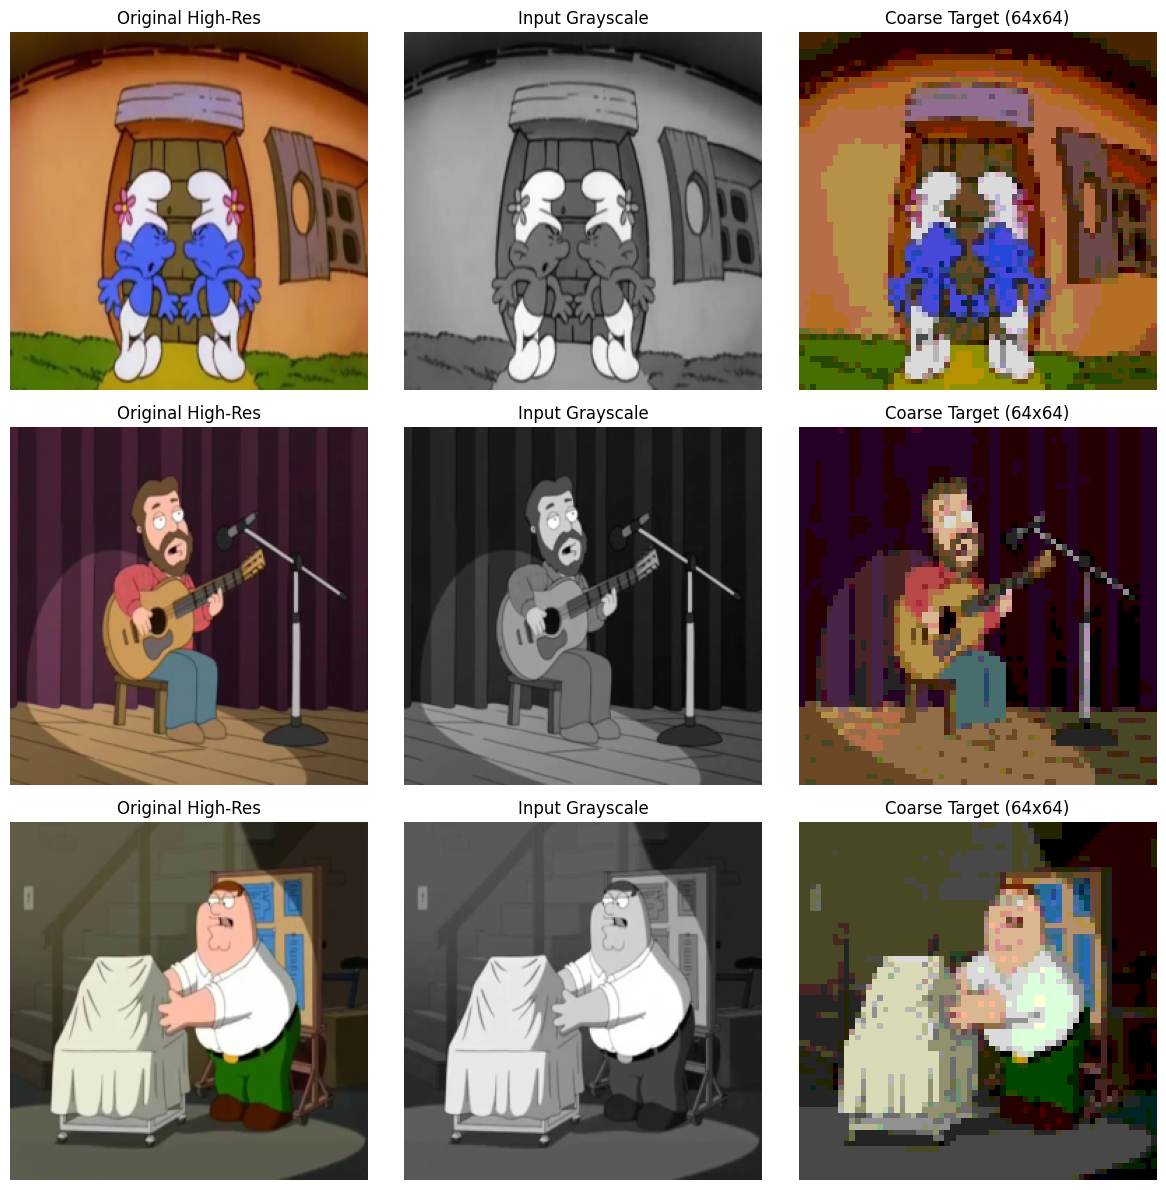

In [51]:
train_ds = CartoonDataset(DATA_ROOT, split='TRAIN', transform=get_transforms())
visualize_dataset(train_ds)

In [ ]:
class AxialAttention(nn.Module):
    def __init__(self, dim, heads, dim_head, axis):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.dim_head = dim_head
        self.scale = dim_head ** -0.5
        self.axis = axis # 1 for height (row), 2 for width (col) inside (B, C, H, W)
        
        inner_dim = heads * dim_head
        self.to_qkv = nn.Conv2d(dim, inner_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(inner_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        
        # Project QKV
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: t.view(b, self.heads, self.dim_head, h, w), qkv)

        # Transpose based on axis to treat the attention axis as the sequence dimension
        if self.axis == 1: # Height axis (Row attention)
            q = q.permute(0, 1, 4, 2, 3) 
            k = k.permute(0, 1, 4, 2, 3)
            v = v.permute(0, 1, 4, 2, 3)
        elif self.axis == 2: # Width axis (Column attention)
            q = q.permute(0, 1, 3, 2, 4)
            k = k.permute(0, 1, 3, 2, 4)
            v = v.permute(0, 1, 3, 2, 4)

        # Dot product attention
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = dots.softmax(dim=-1)
        out = torch.matmul(attn, v)

        # Transpose back
        if self.axis == 1:
            out = out.permute(0, 1, 3, 4, 2)
        elif self.axis == 2:
            out = out.permute(0, 1, 3, 2, 4)
            
        # Reshape to (B, InnerDim, H, W)
        out = out.contiguous().view(b, -1, h, w)
        return self.to_out(out) + x 

class AxialBlock(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.height_attn = AxialAttention(dim, heads, dim_head, axis=1) # Row
        self.width_attn = AxialAttention(dim, heads, dim_head, axis=2)  # Col
        self.norm1 = nn.BatchNorm2d(dim)
        self.norm2 = nn.BatchNorm2d(dim)
        
        self.ff = nn.Sequential(
            nn.Conv2d(dim, dim * 4, 1),
            nn.GELU(),
            nn.Conv2d(dim * 4, dim, 1)
        )
        self.norm3 = nn.BatchNorm2d(dim)

    def forward(self, x):
        x = self.height_attn(self.norm1(x))
        x = self.width_attn(self.norm2(x))
        x = self.ff(self.norm3(x)) + x
        return x

In [ ]:
class ConditionalAxialBlock(nn.Module):
    def __init__(self, dim, context_dim, heads=4, dim_head=32):
        super().__init__()
        self.dim = dim
        self.height_attn = AxialAttention(dim, heads, dim_head, axis=1)
        self.width_attn = AxialAttention(dim, heads, dim_head, axis=2)
        
        # Conditioning projection
        self.cond_proj = nn.Conv2d(context_dim, dim, 1)
        
        self.norm1 = nn.BatchNorm2d(dim)
        self.norm2 = nn.BatchNorm2d(dim)
        
        self.ff = nn.Sequential(
            nn.Conv2d(dim, dim * 4, 1),
            nn.GELU(),
            nn.Conv2d(dim * 4, dim, 1)
        )
        self.norm3 = nn.BatchNorm2d(dim)

    def forward(self, x, context):
        c = self.cond_proj(context)
        # Add context bias
        x = x + c
        
        x = self.height_attn(self.norm1(x))
        x = self.width_attn(self.norm2(x))
        x = self.ff(self.norm3(x)) + x
        return x

class GrayscaleEncoder(nn.Module):
    """Encodes 64x64 Grayscale input."""
    def __init__(self, dim=256, layers=4):
        super().__init__()
        self.to_emb = nn.Conv2d(1, dim, 1)
        self.layers = nn.ModuleList([AxialBlock(dim) for _ in range(layers)])

    def forward(self, x):
        x = self.to_emb(x)
        for layer in self.layers:
            x = layer(x)
        return x


In [ ]:
class ColTranCore(nn.Module):
    def __init__(self, dim=256, num_colors=512, layers=4):
        super().__init__()
        self.dim = dim
        self.num_colors = num_colors
        
        self.encoder = GrayscaleEncoder(dim, layers=2)
        self.color_emb = nn.Embedding(num_colors, dim)
        
        self.decoder_layers = nn.ModuleList([
            ConditionalAxialBlock(dim, context_dim=dim, heads=4) for _ in range(layers)
        ])
        
        self.to_logits = nn.Conv2d(dim, num_colors, 1)

    def forward(self, gray_img, color_seq=None):
        context = self.encoder(gray_img)
        
        b, h, w = gray_img.shape[0], gray_img.shape[2], gray_img.shape[3]
        
        if color_seq is not None:
            x = self.color_emb(color_seq).permute(0, 3, 1, 2) # (B, Dim, H, W)
        else:
            x = torch.zeros((b, self.dim, h, w), device=gray_img.device)

        for layer in self.decoder_layers:
            x = layer(x, context)
            
        return self.to_logits(x)

class SpatialUpsampler(nn.Module):
    def __init__(self, dim=64):
        super().__init__()
        self.to_emb = nn.Conv2d(3 + 1, dim, 3, padding=1) # Input: RGB (upscaled) + Grayscale
        
        # Standard ResNet-like or Conv refinement layers without PixelShuffle
        # as we are operating at the target resolution (256x256)
        self.layers = nn.Sequential(
            nn.Conv2d(dim, dim, 3, padding=1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, padding=1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, padding=1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, padding=1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, 3, 1) # Output RGB
        )

    def forward(self, coarse_rgb, gray_highres):
        coarse_up = F.interpolate(coarse_rgb, size=gray_highres.shape[-2:], mode='bilinear')
        
        x = torch.cat([coarse_up, gray_highres], dim=1)
        x = self.to_emb(x)
        return self.layers(x)


In [ ]:
def train_one_epoch(core, upsampler, loader, opt_core, opt_up, crit_core, crit_up):
    core.train()
    upsampler.train()
    loop = tqdm(loader, leave=True)
    total_loss = 0
    
    for batch in loop:
        # Get data
        gray = batch['gray'].to(DEVICE) # (B, 1, 256, 256)
        rgb = batch['rgb'].to(DEVICE)   # (B, 3, 256, 256)
        
        # Downsample for Core Model (64x64)
        gray_small = torch.nn.functional.interpolate(gray, size=(CORE_SIZE, CORE_SIZE), mode='bilinear')
        rgb_small = torch.nn.functional.interpolate(rgb, size=(CORE_SIZE, CORE_SIZE), mode='bilinear')
        
        # Quantize RGB to indices [0-511]
        target_indices = quantize_color(rgb_small).to(DEVICE) # (B, 64, 64)
        
        # Forward pass Core
        core_logits = core(gray_small, target_indices) # (B, 512, 64, 64)
        loss_core = crit_core(core_logits, target_indices)
        
        opt_core.zero_grad()
        loss_core.backward()
        opt_core.step()
        # We assume "Teacher Forcing" for the upsampler input: use ground truth coarse RGB
        # to ensure it learns to upscale correctly even if Core is not perfect yet.
        
        # Re-dequantize ground truth indices to get the representative colors for input
        input_coarse_rgb = dequantize_color(target_indices, levels=8).to(DEVICE)
        
        # Forward pass Upsampler
        highres_pred = upsampler(input_coarse_rgb, gray)
        loss_up = crit_up(highres_pred, rgb)
        
        opt_up.zero_grad()
        loss_up.backward()
        opt_up.step()
        
        total_loss += (loss_core.item() + loss_up.item())
        loop.set_postfix(loss_core=loss_core.item(), loss_up=loss_up.item())
        
    return total_loss / len(loader)

def visualize_results(core_model, upsampler_model, dataset):
    core_model.eval()
    upsampler_model.eval()
    if len(dataset) == 0: return

    idx = torch.randint(0, len(dataset), (1,)).item()
    data = dataset[idx]
    
    gray = data['gray'].unsqueeze(0).to(DEVICE)
    rgb_gt = data['rgb'].permute(1,2,0).cpu().numpy()
    
    # 1. Coarse Prediction
    gray_small = torch.nn.functional.interpolate(gray, size=(CORE_SIZE, CORE_SIZE), mode='bilinear')
    dummy_input = torch.zeros((1, CORE_SIZE, CORE_SIZE), dtype=torch.long).to(DEVICE)
    
    with torch.no_grad():
        logits = core_model(gray_small, dummy_input)
        probs = torch.softmax(logits, dim=1)
        pred_indices = torch.argmax(probs, dim=1) # (1, 64, 64)
        
        # Dequantize to get Coarse RGB
        pred_coarse_rgb = dequantize_color(pred_indices, levels=8).to(DEVICE)
        
        # 2. Upsample Prediction
        pred_highres = upsampler_model(pred_coarse_rgb, gray)
    
    # Process for display
    pred_coarse_disp = pred_coarse_rgb.squeeze(0).permute(1,2,0).cpu().numpy()
    pred_highres_disp = pred_highres.squeeze(0).permute(1,2,0).cpu().clamp(0, 1).numpy()
    gray_disp = gray.squeeze(0).permute(1,2,0).cpu().numpy()
    
    # Plot
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    
    ax[0].imshow(gray_disp, cmap='gray')
    ax[0].set_title("Input Gray")
    ax[0].axis('off')
    
    ax[1].imshow(pred_coarse_disp)
    ax[1].set_title("Stage 1: Coarse")
    ax[1].axis('off')
    
    ax[2].imshow(pred_highres_disp)
    ax[2].set_title("Stage 2: Final High-Res")
    ax[2].axis('off')
    
    ax[3].imshow(rgb_gt)
    ax[3].set_title("Ground Truth")
    ax[3].axis('off')
    
    plt.show()

In [ ]:
def main():
    if not os.path.exists(DATA_ROOT):
        print(f"Data root {DATA_ROOT} not found. Please check Kaggle paths.")
        return

    print("Loading Dataset...")
    train_ds = CartoonDataset(DATA_ROOT, split='TRAIN', transform=get_transforms())
    print(f"Dataset Size: {len(train_ds)}")
    
    visualize_dataset(train_ds)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    
    print("Initializing ColTran Models...")
    core_model = ColTranCore(dim=256, layers=4).to(DEVICE)
    upsampler_model = SpatialUpsampler().to(DEVICE)
    
    opt_core = optim.Adam(core_model.parameters(), lr=LR)
    opt_up = optim.Adam(upsampler_model.parameters(), lr=LR)
    
    crit_core = nn.CrossEntropyLoss()
    crit_up = nn.MSELoss() # Or L1Loss for sharper images
    
    # Train Loop
    print(f"Starting training on {DEVICE}...")
    for epoch in range(EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
        avg_loss = train_one_epoch(core_model, upsampler_model, train_loader, 
                                   opt_core, opt_up, crit_core, crit_up)
        print(f"Epoch Loss (Combined): {avg_loss:.4f}")
        
        # Visualize predictions
        visualize_results(core_model, upsampler_model, train_ds)
            
    # Save Models
    torch.save(core_model.state_dict(), "coltran_core.pth")
    torch.save(upsampler_model.state_dict(), "coltran_upsampler.pth")
    print("Models saved.")

Loading Dataset...
Dataset Size: 119617


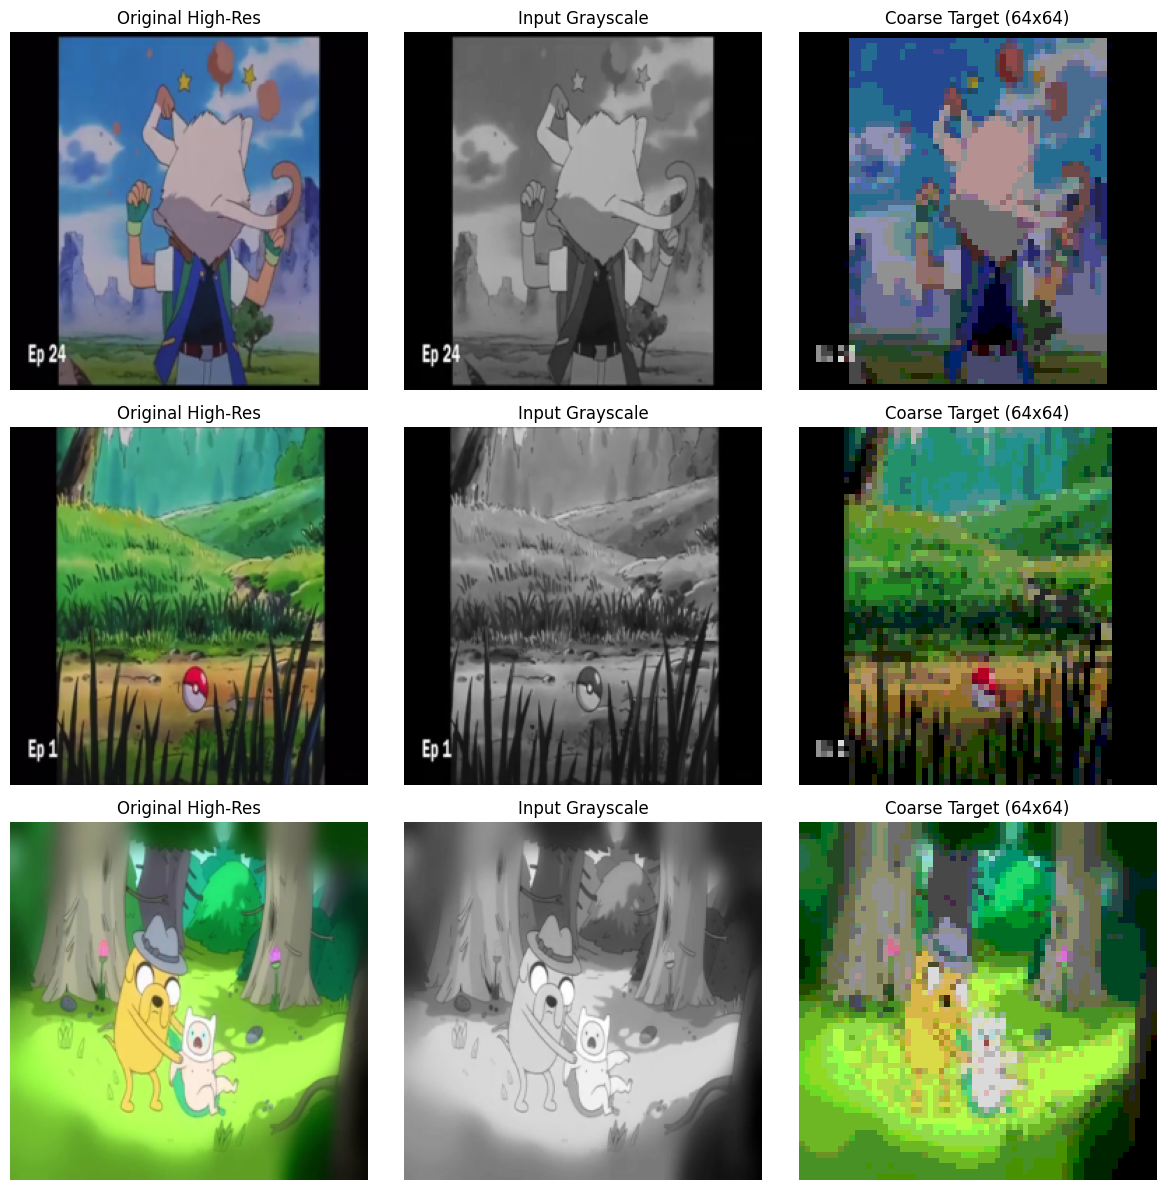

Initializing ColTran Models...
Starting training on cuda...

--- Epoch 1/5 ---


  1%|          | 80/14953 [00:25<1:19:40,  3.11it/s, loss_core=0.0906, loss_up=0.0061]

In [ ]:
if __name__ == "__main__":
    main()